In [309]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.pyplot import savefig
from keras.utils import to_categorical

### Observe Data

In [2]:
fashion_set = fashion_mnist.load_data()

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_set

#### Xem hình ảnh thông qua pyplot

In [246]:
def plot_image(X, y, images_per_row=10, name=''):
    size = 28 #default size X_train.shape
    number_img = X.shape[0]
    X = X.reshape(number_img, size, size)
    no_rows = int(np.ceil(number_img/images_per_row))
    n_empty_image = no_rows * images_per_row - number_img

    #combine input with empty set
    image_set = np.concatenate([X, np.zeros((n_empty_image, size, size))], axis=0)
    label_set = np.concatenate([y, -np.ones(n_empty_image)], axis=0)
    #image_grid = image_set.reshape(no_rows, images_per_row, size, size)
    #images = image_grid.transpose(0,2,1,3).reshape(no_rows * size, images_per_row * size)
    print(image_set.shape)
    #plt.imshow(X=images, , cmap=mpl.cm.binary)
    fig, axes = plt.subplots(nrows=no_rows, ncols=images_per_row, figsize=(images_per_row * 1.5,no_rows))
    fig.tight_layout(pad=0.13, rect=[0, 0.12, 1, 2]) #[left,bottom, right, top]
    
    for (i,ax), y_set in zip(enumerate(axes.flat), label_set):
        ax.imshow(image_set[i], cmap='binary')
        ax.set_title(f'{y_set}')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(name, x=0.5, y=2.25)
    

(6, 28, 28)


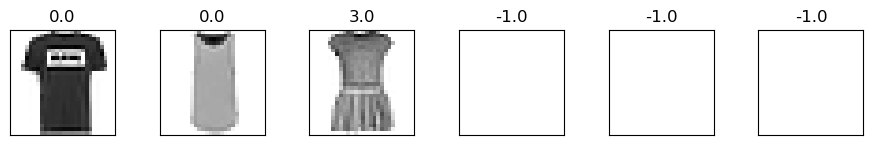

In [247]:
plot_image(X_train[1:4], y_train[1:4], images_per_row=6)

#### Thống kê data

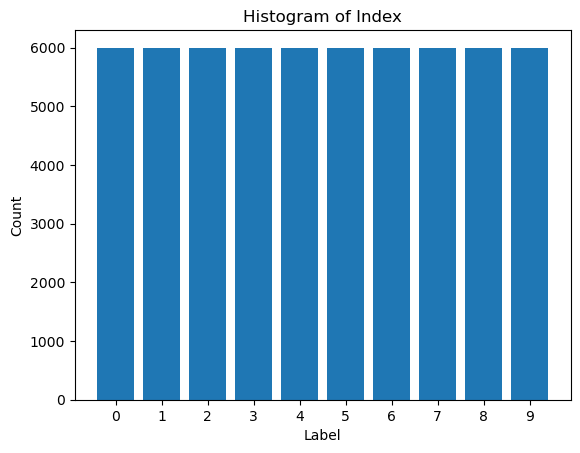

In [7]:
from collections import Counter
import pandas as pd
y_counter = Counter(y_train)
df = pd.DataFrame.from_dict(y_counter, orient='index', columns=['Count']).sort_index(ascending=True)
indexs = df.index
count_n = df['Count']
plt.bar(indexs, count_n, align='center')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Histogram of Index')
plt.xticks(indexs)
savefig('distribution of label.png')
plt.show()    

Dựa vào diagram ở trên có thể thấy số lượng tập train là đồng đều không bị mất cân bằng về các label

### Preprocess Data

Để thuận tiện cho việc tính toán ta cần xử lý data. Thấy rằng giá trị của các tập X đều nằm trong khoảng từ 0 - 255, vì thế ta có thể normalize các giá trị của các tập dữ liệu để dễ dàng tính toán

In [8]:
print(f'giá trị nhỏ nhất: {np.min(X_train)}')
print(f'giá trị lớn nhất: {np.max(X_train)}')

giá trị nhỏ nhất: 0
giá trị lớn nhất: 255


Và vì dùng giải thuật CNN nên phải reshape các tập dữ liệu đầu vào, biết rằng các tập dữ liệu có shape (<b>m</b>, 28, 28) và cần đưa về shape (<b>m</b>, 28, 28, 1)

<b>m</b>: số lượng đầu vào input(ở tập X_train là 60000, ở tập X_test: 10000)

In [9]:
print(f'Shape X_train: {X_train.shape}')
print(f'Shape X_test: {X_test.shape}')

Shape X_train: (60000, 28, 28)
Shape X_test: (10000, 28, 28)


Vì cần xử lí 2 vấn đề ở trên nên tiến hành tạo 1 pipeline cho phép xử lý data:

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    def fit(self, X, y=None): 
        return self
    def transform(self, X, y=None):
        X_process = X/255
        return X_process.reshape(X.shape[0], 28, 28, 1)

In [11]:
processor = Pipeline([
    ('Process', Preprocessor())
])  

### import model

In [12]:
#Split Data from train set to train and cross set
from sklearn.model_selection import train_test_split
X_train_, X_cross_, y_train_,  y_cross = train_test_split(X_train, y_train, random_state=42, train_size=0.8, stratify=y_train)

### Implement thuần CNN

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [166]:
#input shape(28, 28)

model = Sequential([
    Conv2D(32, (5,5), activation='relu', input_shape=(28,28,1)),
    Conv2D(16, (3,3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='linear')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))

In [14]:
X_train_process = processor.fit_transform(X_train_)
X_cross_process = processor.transform(X_cross_)

In [15]:
print(np.max(X_cross_process[:1]))

1.0


In [169]:
model.fit(X_train_process, y_train_, verbose=1, epochs=20, validation_data=(X_cross_process, y_cross))

Epoch 1/20
1500/1500 [==============================] - 74s 49ms/step - loss: 0.4350 - accuracy: 0.8420 - val_loss: 0.3144 - val_accuracy: 0.8844
Epoch 2/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.2856 - accuracy: 0.8938 - val_loss: 0.2924 - val_accuracy: 0.8912
Epoch 3/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.2335 - accuracy: 0.9117 - val_loss: 0.2556 - val_accuracy: 0.9074
Epoch 4/20
1500/1500 [==============================] - 68s 45ms/step - loss: 0.1948 - accuracy: 0.9258 - val_loss: 0.2477 - val_accuracy: 0.9125
Epoch 5/20
1500/1500 [==============================] - 65s 43ms/step - loss: 0.1608 - accuracy: 0.9391 - val_loss: 0.2600 - val_accuracy: 0.9118
Epoch 6/20
1500/1500 [==============================] - 65s 43ms/step - loss: 0.1265 - accuracy: 0.9522 - val_loss: 0.2939 - val_accuracy: 0.9038
Epoch 7/20
1500/1500 [==============================] - 64s 43ms/step - loss: 0.1002 - accuracy: 0.9616 - val_loss: 0.3078 -

In [171]:
from sklearn.metrics import accuracy_score
X_test_process = processor.transform(X_test)
y_pred = np.argmax(model.predict(X_test_process), axis=1)
#print(X_test_process.shape, y_pred.shape)
print(accuracy_score(y_test, y_pred))

313/313 [==============================] - 2s 6ms/step
0.9038


### Nhận xét khi Implement thuần

In [177]:
model.history.history

{}

In [173]:
history_acc[['accuracy', 'val_accuracy']].plot()
k = plt.xticks(history_acc.index)
savfig('acc_vs_cv_acc_before_tuning_model.png')

KeyError: "None of [Index(['accuracy', 'val_accuracy'], dtype='object')] are in the [columns]"

Nhận thấy có 1 khoảng cách rất lớn giữa accuracy và val_accuracy ==> High variance

In [170]:
model.save('model_before_tuning.h5')

INFO:tensorflow:Assets written to: model_before_tuning.pkl\assets


INFO:tensorflow:Assets written to: model_before_tuning.pkl\assets


### Xử lý High Variance problem

### Tuning model

#### Để tiến hành giảm High Variance problem chúng ta có thể thực hiện các bước sau
- Lấy thêm nhiều dữ liệu
- Regularization
- Tìm thêm Neural Network architecture

#### Lấy thêm dữ liệu

Sử dụng phương pháp augement data để có thể tạo thêm nhiều dữ liệu cho tập train

In [17]:
from keras.preprocessing.image import ImageDataGenerator


#### 
* RandomFlip
* RandomRotation
* Shifting
* Zoom

In [184]:
data_generator = ImageDataGenerator(rotation_range=10, zoom_range=0.1, 
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    fill_mode='nearest', cval=0)

In [173]:
data_generator.fit(X_train_process)

In [198]:
batch = data_generator.flow(X_train_process, y_train_, seed=42, batch_size=128)
batch.image_data_generator

In [282]:
X_batch, y_batch = data_generator.flow(X_train_process, y_train_, batch_size=10, shuffle=False).next()

(10, 28, 28)
(10, 28, 28)


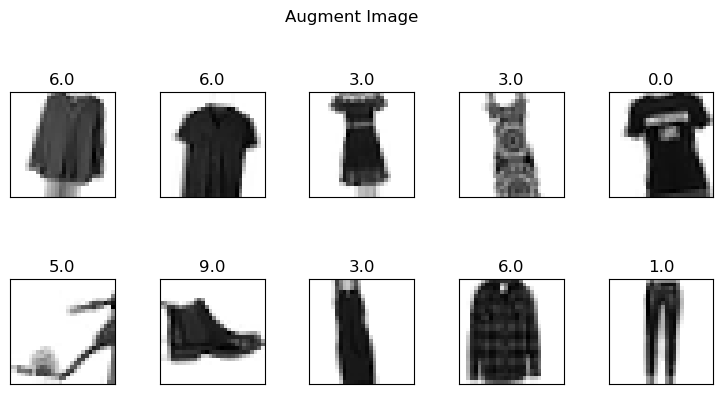

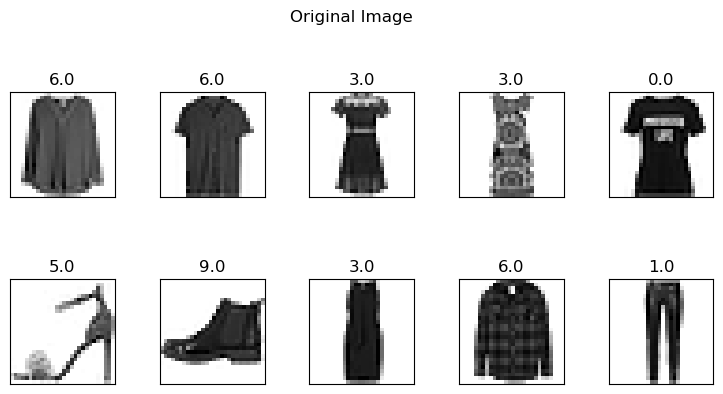

In [285]:
plot_image(X_batch[:10], y_batch[:10], 5, 'Augment Image')
plot_image(X_train_process[:10], y_batch[:10], 5, 'Original Image')

#### 

In [257]:
X_augment, y_augment = data_generator.flow(X_train_process, y_train_, batch_size=X_train_process.size).next()

In [289]:
X_augment_train = np.concatenate((X_augment, X_train_process), axis=0)
y_augment_train = np.concatenate((y_augment, y_train_), axis=0)
print(y_augment_train.shape)
shuffle_indices = np.random.permutation(X_augment_train.shape[0])
X_augment_train = X_augment_train[shuffle_indices]
y_augment_train = y_augment_train[shuffle_indices]

(96000,)


(10, 28, 28)


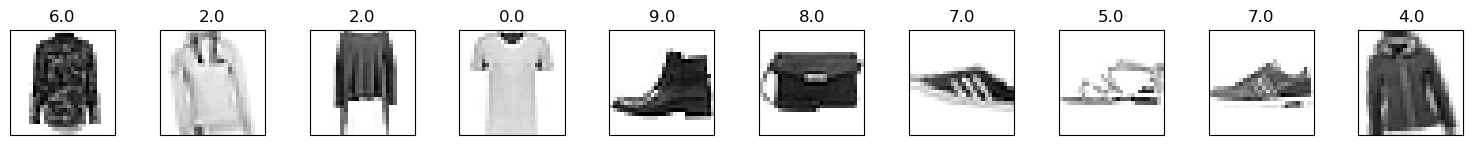

In [290]:
plot_image(X_augment_train[:10], y_augment_train[:10])

### Regularization

* Sử dụng L2Regularization (Weight decay)
* Dropout

In [131]:
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import MaxPooling2D, AveragePooling2D

In [139]:
def create_model(kernel_regular = 0.1, pool_type='max', dropout_rate=0.0):
    model_reg = Sequential()
    model_reg.add(Conv2D(64, (5,5), activation='relu', input_shape=(28,28,1)))
    if pool_type=='max':
        model_reg.add(MaxPooling2D(pool_size=(2,2)))
    elif pool_type=='average':
        model_reg.add(AveragePooling2D(pool_size=(2,2)))

    model_reg.add(Conv2D(32, (5,5), activation='relu'))
    model_reg.add(Flatten())
    model_reg.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(kernel_regular)))

    if dropout_rate != 0.0:
        model_reg.add(Dropout(dropout_rate))
    model_reg.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(kernel_regular)))
    if dropout_rate != 0.0:
        model_reg.add(Dropout(dropout_rate))
    model_reg.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(kernel_regular)))
    model_reg.add(Dense(10, activation='linear'))

    model_reg.compile(optimizer='adam', metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))
    return model_reg

In [142]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience=5, restore_best_weights=True)

In [141]:
param_grid = {}
param_grid['epochs'] = [10, 20]
param_grid['model__dropout_rate'] = [0.0, 0.10, 0.20, 0.30]
param_grid['model__pool_type'] = ['max', 'average']
param_grid['model__kernel_regular'] = [0.01, 0.1]


In [58]:
#%pip install scikeras

In [143]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
model_wrapper = KerasClassifier(build_fn=create_model, epochs=10, verbose=1)
grid = GridSearchCV(model_wrapper, param_grid=param_grid, cv=3, verbose=1)

In [ ]:
model_wrapper.get_params().keys()

In [291]:
grid_result = grid.fit(X_augment_train, y_augment_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


d:\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
  71/2400 [..............................] - ETA: 2:46 - loss: 4.3988 - accuracy: 0.4626

KeyboardInterrupt: 

In [ ]:
model_reg.save('model_after_tuning.pkl')

In [190]:
history_acc_v2 = pd.DataFrame(model_reg.history.history) 
history_acc_v2

,loss,accuracy,val_loss,val_accuracy
0,0.595531,0.835099,0.456424,0.883000
1,0.587209,0.838063,0.436308,0.891250
2,0.582630,0.839589,0.445311,0.890583
3,0.577742,0.840896,0.449054,0.888083
4,0.571885,0.842469,0.446341,0.889833
5,0.568551,0.844651,0.433837,0.893417
6,0.564164,0.846359,0.442151,0.889167
7,0.563000,0.847099,0.443529,0.890583
8,0.559973,0.848609,0.426995,0.895250
9,0.556908,0.849422,0.455090,0.890500


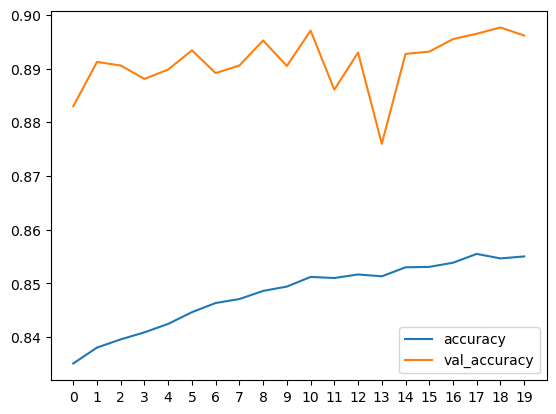

In [192]:
history_acc_v2[['accuracy', 'val_accuracy']].plot()
k = plt.xticks(history_acc_v2.index)

In [193]:
y_pred_reg = np.argmax(model_reg.predict(X_test_process), axis=1)
accuracy_score(y_test, y_pred_reg)

313/313 [==============================] - 2s 5ms/step


0.8849

### Transfer Learning

In [374]:
#%pip install tensorflow_hub 

In [413]:
from tensorflow.keras.applications.resnet50 import preprocess_input,ResNet50

In [444]:
model_transfer = Sequential()

model_transfer.add(ResNet50(include_top = False, input_shape=(32,32,3)))
model_transfer.add(Dense(units=10, activation='linear'))
model_transfer.layers[0].trainable=False
model_transfer.compile(optimizer='adam', metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))


In [445]:
model_transfer.summary()

Model: "sequential_348"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 dense_184 (Dense)           (None, 1, 1, 10)          20490     
                                                                 
Total params: 23608202 (90.06 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Preprocess Data

In [446]:
def expand_gray_scale(X_train):
    X_train_3_channel = X_train.repeat(3, axis=-1) #expand to 3 dimension
    X_train_3_channel = tf.image.resize(X_train_3_channel, [32,32])
    return X_train_3_channel

In [439]:
X_augment_train_3 = expand_gray_scale(X_augment_train)

In [441]:
X_augment_train_3.shape

TensorShape([96000, 32, 32, 3])

In [447]:
history_model = model_transfer.fit(X_augment_train_3, y_augment_train, verbose=1)

 126/3000 [>.............................] - ETA: 4:09 - loss: 2.4911 - accuracy: 0.1004

KeyboardInterrupt: 